#### Import Libraries & Set Config

In [2]:
# data tools
import numpy as np
import polars as pl
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import timedelta, date

# stats tools
from scipy.optimize import minimize
import statsmodels.api as sm
from functools import reduce
import datetime

# visualization tools
from matplotlib.gridspec import GridSpec
import matplotlib.patches as mpatches

# misc tools
import tqdm
import os

In [3]:
# Set professional style globally
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans']
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3
plt.rcParams['axes.facecolor'] = '#f8f9fa'
plt.rcParams['figure.facecolor'] = 'white'

#### Define Model

In [6]:
class FactorModel:
    """
    A class to handle data loading, factor calculation, portfolio formation, and
    backtesting against factor models.
    """

    def __init__(self,
                 start=datetime.date(1970, 12, 31),
                 end=datetime.date(2024, 12, 31)):
        self.start, self.end = start, end
        self.factors_df = None
        self.portfolios_df = None
        self.n_quantiles = -1
        self.data = None
        
        self.load_data()
        if self.data is not None:
            self.compute_factors()

    # 1. FACTOR MODELING

    def load_data(self):
        def _load_compustat():
            comp = pl.read_csv("data/compustat_1970.csv", null_values=[''], ignore_errors=True)
            comp.columns = [col.lower() for col in comp.columns]
            return comp.with_columns(pl.col("public_date").str.to_date().alias("date")).drop_nulls("date")

        def _load_crsp():
            na_values = [chr(i) for i in range(65, 91)]
            crsp = pl.read_csv("data/crsp_1964.csv", null_values=na_values, ignore_errors=True)
            crsp.columns = [col.lower() for col in crsp.columns]
            return crsp.with_columns(pl.col("date").str.to_date().alias("date")).drop_nulls("date")
        
        def _load_rf_rates():
            rf = pl.read_csv("data/risk_free_rates.csv")
            return rf.with_columns(pl.col("dateff").str.to_date().alias("date"))

        try:
            crsp = _load_crsp().sort('permno', 'date', maintain_order=True)
            comp = _load_compustat().sort('permno', 'date', maintain_order=True)
            rf = _load_rf_rates().sort('date', maintain_order=True)
            data = crsp.join(comp, on=["permno", "date"], how="inner").join(rf, on="date")
            self.data = (
                data.sort('permno', 'date', maintain_order=True)
                .filter(
                    pl.col('date').is_between(self.start, self.end) &
                    pl.col('prc').is_not_null() &
                    pl.col('prc').abs().gt(1)
                )
                .unique(['permno', 'date'], keep='last', maintain_order=True) 
            )

            duplicates = self.data.group_by(['permno', 'date']).agg(pl.len().alias('count')).filter(pl.col('count') > 1)

        except Exception as e:
            print(f"Error reading or processing data files: {e}")
            self.data = None

    def compute_factors(self):
        if self.data is None or self.data.is_empty():
            print("Data is not available. Cannot compute factors.")
            return

        monthly_snapshot = self.data.sort('permno', 'date').group_by_dynamic(
            'date', every='1mo', group_by='permno'
        ).agg([
            (pl.col('ret') + 1).product().alias('ret_prod'), pl.last('prc'), pl.last('shrout'),
            pl.last('bm'), pl.last('gprof'), pl.last('accrual'), pl.last('totdebt_invcap'),
            pl.last('equity_invcap'), pl.last('vwretd')
        ]).with_columns((pl.col('ret_prod') - 1).alias('ret')).drop('ret_prod')

        monthly_df = monthly_snapshot.sort('permno', 'date').with_columns(
            pl.col(['bm', 'gprof', 'accrual', 'totdebt_invcap', 'equity_invcap']).forward_fill().over('permno')
        )
        
        window_size = 36
        factors_df = (
            monthly_df.sort('permno', 'date')
            .with_columns([
                (pl.rolling_cov("vwretd", "ret", window_size=window_size) / pl.col("vwretd").rolling_var(window_size=window_size)).over("permno").alias("beta"),
                (pl.col('shrout') * pl.col('prc').abs()).shift(1).over('permno').alias('me'),
                (pl.col('totdebt_invcap') + pl.col('equity_invcap')).alias('invcap'),
            ]).with_columns([
                (pl.col('invcap') / pl.col('invcap').shift(12).over('permno') - 1).alias('investment'),
                ((pl.col('ret') + 1).cum_prod().over('permno') / (pl.col('ret') + 1).cum_prod().over('permno').shift(11)).alias('ret_11m_prod')
            ]).with_columns([
                (pl.col('ret_11m_prod').shift(2).over('permno') - 1).alias('momentum')
            ]).with_columns([
                (pl.col("ret") - (pl.col("beta") * pl.col("vwretd"))).alias("residual"),
            ]).with_columns([
                pl.col("residual").rolling_std(window_size=12).over("permno").alias("idiosyncratic_risk"),
            ])
        )

        self.factors_df = factors_df.select([
            'permno', 'date', 'ret', 'beta', pl.col('me').alias('size'), pl.col('bm').alias('value'),
            'momentum', pl.col('gprof').alias('profitability'), 'investment', 'accrual', 'idiosyncratic_risk'
        ]).drop_nulls()

    def sort_into_quantiles(self, factor_names: str | list[str] | None = None, n_quantiles: int = 5):
        if self.factors_df is None: return None
        self.n_quantiles = n_quantiles
        
        if factor_names is None:
            factors_to_process = [c for c in self.factors_df.columns if c not in ['permno', 'date', 'ret']]
        else:
            factors_to_process = [factor_names] if isinstance(factor_names, str) else factor_names
    
        if missing := [f for f in factors_to_process if f not in self.factors_df.columns]:
            print(f"Error: The following factors were not found: {missing}"); return None
        
        expressions = [
            pl.col(f).qcut(n_quantiles, labels=[str(i) for i in range(1, n_quantiles + 1)], allow_duplicates=True).alias(f"portfolio_{f}")
            for f in factors_to_process
        ]
        self.portfolios_df = self.factors_df.group_by('date').map_groups(lambda g: g.with_columns(expressions))
        return self.portfolios_df

    def backtest_long_short(self, factor_name: str, weighting: str = 'ew', long_highest_quantile: bool = True):
        if self.portfolios_df is None: return None
        portfolio_col = f"portfolio_{factor_name}"
        if portfolio_col not in self.portfolios_df.columns: return None

        backtest_df = self.portfolios_df.with_columns(pl.col('ret').shift(-1).over('permno').alias('forward_ret'))

        if weighting == 'ew':
            monthly_returns = backtest_df.group_by('date', portfolio_col).agg(pl.col('forward_ret').mean().alias('portfolio_ret'))
        else:
            monthly_returns = backtest_df.group_by('date', portfolio_col).agg(((pl.col('forward_ret') * pl.col('size')).sum() / pl.col('size').sum()).alias('portfolio_ret'))

        pivot_returns = monthly_returns.pivot(index='date', on=portfolio_col, values='portfolio_ret').sort('date')
        
        low_q, high_q = '1', str(self.n_quantiles)
        
        if high_q not in pivot_returns.columns or low_q not in pivot_returns.columns: return None
            
        if long_highest_quantile:
            pivot_returns = pivot_returns.with_columns((pl.col(high_q).fill_null(0) - pl.col(low_q).fill_null(0)).alias('long_short'))
        else:
            pivot_returns = pivot_returns.with_columns((pl.col(low_q).fill_null(0) - pl.col(high_q).fill_null(0)).alias('long_short'))
        
        renamed_cols = {str(i): f"P{i}" for i in range(1, self.n_quantiles + 1)}
        renamed_cols['long_short'] = 'long_short'
        
        final_cols = ['date'] + [col for col in renamed_cols if col in pivot_returns.columns]
        return pivot_returns.select(final_cols).rename(renamed_cols).drop_nulls('date')

    def backtest_all_factors_long_short(self, weighting: str = 'vw'):
        if self.portfolios_df is None: return self
        factor_names = [c.replace('portfolio_', '') for c in self.portfolios_df.columns if c.startswith('portfolio_')]
        low_is_good = {'size', 'accrual', 'value'}

        all_returns = []
        for f in factor_names:
            result = self.backtest_long_short(f, weighting, (f not in low_is_good))
            if result is not None:
                all_returns.append(result.select(['date', pl.col('long_short').alias(f)]))

        if not all_returns: return self

        self.backtest_results = reduce(lambda l, r: l.join(r, on='date', how='full', coalesce=True), all_returns).sort('date')
        return self

    # 2. FACTOR OPTIMIZATION

    def calc_factor_covariance(self, annualize=True):
        """
        Calculate covariance and correlation matrices of factor returns.
        """
        if not hasattr(self, 'backtest_results') or self.backtest_results is None:
            print("Backtest results not found. Run backtest_all_factors_long_short() first.")
            return None, None, None
        
        # Get factor columns
        factor_cols = [col for col in self.backtest_results.columns if col != 'date']
        
        if not factor_cols:
            print("No factors found in backtest results.")
            return None, None, None
        
        # Convert to numpy, fill nulls with 0
        returns_matrix = self.backtest_results.select(factor_cols).fill_null(0).to_numpy()
        
        # Calculate covariance and correlation
        cov_matrix = np.cov(returns_matrix.T)
        corr_matrix = np.corrcoef(returns_matrix.T)
        
        if annualize:
            cov_matrix = cov_matrix * 12  # Monthly to annual
        
        return cov_matrix, corr_matrix, factor_cols

    def optimize_factor_weights(self, method='mean_variance', target_vol=0.15, 
                            risk_free_rate=0.02, allow_short=False):
        """
        Optimize weights across multiple factors.
        
        Parameters:
        - method: 'mean_variance', 'min_variance', 'risk_parity', 'equal_weight', 'max_sharpe'
        - target_vol: Target annualized volatility (for mean_variance)
        - risk_free_rate: Annual risk-free rate (for Sharpe ratio)
        - allow_short: If True, allow negative weights (short positions)
        
        Returns:
        - dict: Optimal weights for each factor
        """
        if not hasattr(self, 'backtest_results') or self.backtest_results is None:
            print("Backtest results not found. Run backtest_all_factors_long_short() first.")
            return None
        
        cov_matrix, _, factor_names = self.calc_factor_covariance(annualize=True)
        if cov_matrix is None:
            return None
        
        # Calculate annualized mean returns
        factor_cols = [col for col in self.backtest_results.columns if col != 'date']
        returns_df = self.backtest_results.select(factor_cols).fill_null(0)
        mean_returns = returns_df.mean().to_numpy()[0] * 12  # Annualized
        
        n_factors = len(factor_names)
        
        # Different optimization methods
        if method == 'equal_weight':
            weights = np.ones(n_factors) / n_factors
            
        elif method == 'min_variance':
            # Minimize: w' * Cov * w
            def objective(w):
                return w @ cov_matrix @ w
            
            constraints = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}
            bounds = None if allow_short else tuple((0, 1) for _ in range(n_factors))
            x0 = np.ones(n_factors) / n_factors
            
            result = minimize(objective, x0, method='SLSQP', bounds=bounds, constraints=constraints)
            weights = result.x
            
        elif method == 'max_sharpe':
            # Maximize Sharpe: (mu - rf) / sqrt(w' * Cov * w)
            # Equivalent to minimizing negative Sharpe
            def objective(w):
                portfolio_return = w @ mean_returns
                portfolio_vol = np.sqrt(w @ cov_matrix @ w)
                sharpe = (portfolio_return - risk_free_rate) / portfolio_vol
                return -sharpe  # Minimize negative Sharpe
            
            constraints = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}
            bounds = None if allow_short else tuple((0, 1) for _ in range(n_factors))
            x0 = np.ones(n_factors) / n_factors
            
            result = minimize(objective, x0, method='SLSQP', bounds=bounds, constraints=constraints)
            weights = result.x
            
        elif method == 'mean_variance':
            # Maximize: mu' * w - lambda * w' * Cov * w
            # where lambda is chosen to hit target volatility
            def objective(w):
                portfolio_vol = np.sqrt(w @ cov_matrix @ w)
                return (portfolio_vol - target_vol) ** 2
            
            constraints = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}
            bounds = None if allow_short else tuple((0, 1) for _ in range(n_factors))
            x0 = np.ones(n_factors) / n_factors
            
            result = minimize(objective, x0, method='SLSQP', bounds=bounds, constraints=constraints)
            weights = result.x
            
        elif method == 'risk_parity':
            # Each factor contributes equally to portfolio risk
            def objective(w):
                portfolio_var = w @ cov_matrix @ w
                marginal_contrib = cov_matrix @ w
                risk_contrib = w * marginal_contrib
                target_risk = portfolio_var / n_factors
                return np.sum((risk_contrib - target_risk) ** 2)
            
            constraints = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}
            bounds = tuple((0.001, 1) for _ in range(n_factors))  # Small lower bound for stability
            x0 = np.ones(n_factors) / n_factors
            
            result = minimize(objective, x0, method='SLSQP', bounds=bounds, constraints=constraints)
            weights = result.x
        
        else:
            print(f"Unknown method: {method}")
            return None
        
        # Create weights dictionary
        weights_dict = {factor_names[i]: weights[i] for i in range(n_factors)}
        
        # Print results
        print("OPTIMAL FACTOR WEIGHTS")
        for factor, weight in sorted(weights_dict.items(), key=lambda x: -x[1]):
            print(f"{factor:20s}: {weight:7.1%}")
        
        return weights_dict

    def backtest_combined_portfolio(self, weights):
        """
        Backtest a portfolio that combines multiple factors using given weights.
        
        Parameters:
        - weights: dict of factor weights, e.g., {'momentum': 0.4, 'value': 0.3, ...}
        
        Returns:
        - DataFrame with combined portfolio returns
        """
        if not hasattr(self, 'backtest_results') or self.backtest_results is None:
            print("Backtest results not found. Run backtest_all_factors_long_short() first.")
            return None
        
        if weights is None or not weights:
            print("No weights provided.")
            return None
        
        # Validate weights
        factor_cols = [col for col in self.backtest_results.columns if col != 'date']
        missing_factors = [f for f in weights.keys() if f not in factor_cols]
        if missing_factors:
            print(f"Warning: Factors not found in backtest results: {missing_factors}")
        
        # Normalize weights to sum to 1
        total_weight = sum(weights.values())
        normalized_weights = {k: v/total_weight for k, v in weights.items()}
        
        # Calculate combined portfolio returns
        combined_expr = pl.lit(0.0)
        for factor, weight in normalized_weights.items():
            if factor in factor_cols:
                combined_expr = combined_expr + (pl.col(factor).fill_null(0) * weight)
        
        combined_portfolio = self.backtest_results.select([
            'date',
            combined_expr.alias('combined_portfolio')
        ])
        
        # Store in backtest_results for analyze_performance to use
        self.backtest_results = self.backtest_results.join(combined_portfolio, on='date', how='left')
        
        print(f"Combined portfolio created with {len(normalized_weights)} factors.")
        return combined_portfolio

    def train_test_split(self, train_end_date, test_start_date=None):
        """
        Split the factor model into in-sample (training) and out-of-sample (test) periods.
        
        Parameters:
        - train_end_date: Last date of training period (datetime.date)
        - test_start_date: First date of test period (default: day after train_end_date)
        
        Returns:
        - tuple: (train_model, test_model)
        """
        if test_start_date is None:
            test_start_date = train_end_date + timedelta(days=1)
        
        print("="*70)
        print(f"Training period:   {self.start} to {train_end_date}")
        print(f"Test period:       {test_start_date} to {self.end}")
        print("="*70)
        
        # Create training model
        train_model = FactorModel(start=self.start, end=train_end_date)
        
        # Create test model
        test_model = FactorModel(start=test_start_date, end=self.end)
        
        return train_model, test_model

    def optimize_and_backtest_oos(self, train_end_date, test_start_date=None,
                                optimization_method='max_sharpe', 
                                n_quantiles=5, weighting='vw', factor_names=None):
        """
        Complete workflow: train on in-sample data, optimize weights, test out-of-sample.
        
        Parameters:
        - train_end_date: Last date of training period
        - test_start_date: First date of test period (default: day after train_end_date)
        - optimization_method: Method for optimizing weights
        - n_quantiles: Number of quantiles for portfolio sorting
        - weighting: 'ew' or 'vw' for portfolio weighting
        - factor_names: List of factors to include (None = all factors)
        
        Returns:
        - dict with keys: 'train_model', 'test_model', 'optimal_weights', 'is_performance', 'oos_performance'
        """
        # Split data
        train_model, test_model = self.train_test_split(train_end_date, test_start_date)
        
        # ===== IN-SAMPLE: Learn the weights =====
        print("\n" + "="*70)
        print("STEP 1: IN-SAMPLE OPTIMIZATION")
        print("="*70)
        
        train_model.sort_into_quantiles(factor_names=factor_names, n_quantiles=n_quantiles)
        train_model.backtest_all_factors_long_short(weighting=weighting)
        
        optimal_weights = train_model.optimize_factor_weights(method=optimization_method)
        
        if optimal_weights is None:
            print("Optimization failed.")
            return None
        
        train_model.backtest_combined_portfolio(optimal_weights)
        
        print("\nIN-SAMPLE Performance:")
        train_model.analyze_performance()
        
        # ===== OUT-OF-SAMPLE: Test those weights =====
        print("\n" + "="*70)
        print("STEP 2: OUT-OF-SAMPLE TESTING")
        print("="*70)
        print(f"Applying weights learned from training period...\n")
        
        test_model.sort_into_quantiles(factor_names=factor_names, n_quantiles=n_quantiles)
        test_model.backtest_all_factors_long_short(weighting=weighting)
        test_model.backtest_combined_portfolio(optimal_weights)
        
        print("OUT-OF-SAMPLE Performance:")
        test_model.analyze_performance()
        
        return {
            'train_model': train_model,
            'test_model': test_model,
            'optimal_weights': optimal_weights,
            'is_performance': train_model.performance_summary if hasattr(train_model, 'performance_summary') else None,
            'oos_performance': test_model.performance_summary if hasattr(test_model, 'performance_summary') else None
        }
    
    # 3. VISUALIZATION
    def analyze_performance(self):
        """Performance analysis with built-in table display"""
        if not hasattr(self, 'backtest_results') or self.backtest_results is None:
            print("Backtest results not found. Please run `backtest_all_factors_long_short()` first.")
            return self
        
        market_data = (
            self.data
            .sort('date')
            .group_by_dynamic('date', every='1mo')
            .agg([
                pl.last('vwretd').alias('mkt'),
                pl.last('rf')
            ]).sort('date')
        )

        analysis_df = self.backtest_results.join(market_data, on='date', how='inner')
        factor_names = [col for col in self.backtest_results.columns if col != 'date']
        
        perf_metrics = []
        for factor in factor_names:
            factor_series = analysis_df.select(factor, 'mkt', 'rf').drop_nulls()
            if len(factor_series) < 12: continue

            annualized_return = factor_series[factor].mean() * 12
            annualized_volatility = factor_series[factor].std() * np.sqrt(12)
            
            if annualized_volatility == 0:
                annualized_sharpe = np.nan
            else:
                annualized_sharpe = (annualized_return - (factor_series['rf'].mean() * 12)) / annualized_volatility

            y = (factor_series[factor] - factor_series['rf']).to_numpy()
            X_np = (factor_series['mkt'] - factor_series['rf']).to_numpy()
            X_with_intercept = np.column_stack([np.ones(len(X_np)), X_np])

            model = sm.OLS(y, X_with_intercept).fit()
            
            annualized_alpha = model.params[0] * 12
            tracking_error = model.resid.std() * np.sqrt(12)
            information_ratio = annualized_alpha / tracking_error if tracking_error > 0 else 0.0

            perf_metrics.append({
                'factor': factor, 'Return (Ann.)': annualized_return, 'Volatility (Ann.)': annualized_volatility,
                'Sharpe Ratio': annualized_sharpe, 'Alpha (Ann.)': annualized_alpha, 'Info. Ratio': information_ratio,
            })

        if not perf_metrics:
            print("Not enough data to compute performance metrics."); return self

        self.performance_summary = pl.DataFrame(perf_metrics).with_columns(pl.all().exclude('factor').round(4))
        
        # Simple table display - no external dependencies
        print("\n" + "="*90)
        print("PERFORMANCE SUMMARY")
        print("="*90)
        print(f"{'Factor':<20} {'Return':>10} {'Volatility':>12} {'Sharpe':>10} {'Alpha':>10} {'Info Ratio':>12}")
        print("-" * 90)
        
        for metric in perf_metrics:
            print(f"{metric['factor']:<20} {metric['Return (Ann.)']:>9.1%} {metric['Volatility (Ann.)']:>11.1%} "
                f"{metric['Sharpe Ratio']:>9.3f} {metric['Alpha (Ann.)']:>9.2%} {metric['Info. Ratio']:>11.3f}")
        
        print("="*90)
        
        return self

    def plot_performance(self, focus_factors=None):
        """
        Combined performance visualization - cumulative returns + correlation heatmap
        """
        if not hasattr(self, 'backtest_results') or self.backtest_results is None:
            print("Backtest results not found.")
            return self
        
        # Filter factors if specified
        factor_names = [col for col in self.backtest_results.columns if col != 'date']
        if focus_factors:
            factor_names = [f for f in factor_names if f in focus_factors]
        
        # Create figure with two subplots stacked vertically
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 20), dpi=150)
        
        # 1. Cumulative returns plot (top)
        cumulative_returns = self.backtest_results.with_columns([
            ((pl.col(factor).fill_null(0) + 1).cum_prod() - 1).alias(factor)
            for factor in factor_names
        ])
        
        plot_df = cumulative_returns.to_pandas()
        plot_df['date'] = pd.to_datetime(plot_df['date'])
        plot_df = plot_df.set_index('date')
        
        # Better color palette
        colors = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D', '#3B1F2B', '#6B8E23', '#4B0082']
        
        # Plot all factors with better colors
        for i, factor in enumerate(factor_names):
            color = colors[i % len(colors)]
            linewidth = 3 if factor == 'combined_portfolio' else 2
            alpha = 1.0 if factor == 'combined_portfolio' else 0.8
            linestyle = '-' if factor == 'combined_portfolio' else '-'
            
            ax1.plot(plot_df.index, plot_df[factor], 
                    label=factor.replace('_', ' ').title(), 
                    linewidth=linewidth, alpha=alpha, 
                    color=color, linestyle=linestyle)
        
        ax1.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.3)
        ax1.set_xlabel('Date')
        ax1.set_ylabel('Cumulative Return')
        ax1.set_title('Cumulative Factor Returns', fontsize=14, fontweight='bold')
        ax1.legend(loc='upper left', frameon=True, fancybox=True, shadow=True)
        ax1.grid(True, alpha=0.3)
        ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))
        
        # 2. Correlation heatmap (bottom)
        factor_cols = [col for col in self.backtest_results.columns if col != 'date']
        returns_df = self.backtest_results.select(factor_cols).fill_null(0).to_pandas()
        
        if focus_factors:
            returns_df = returns_df[focus_factors]
        
        corr_matrix = returns_df.corr()
        
        # Use a better colormap
        im = ax2.matshow(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)
        
        # Add correlation values as text
        for i in range(len(corr_matrix)):
            for j in range(len(corr_matrix)):
                value = corr_matrix.iloc[i, j]
                # Use white text for dark backgrounds, black for light
                text_color = 'white' if abs(value) > 0.5 else 'black'
                ax2.text(j, i, f'{value:.2f}', 
                        ha='center', va='center', fontsize=10,
                        color=text_color, fontweight='bold')
        
        # Set ticks and labels
        tick_labels = [col.replace('_', ' ').title() for col in corr_matrix.columns]
        ax2.set_xticks(range(len(corr_matrix.columns)))
        ax2.set_yticks(range(len(corr_matrix.columns)))
        ax2.set_xticklabels(tick_labels, rotation=45, ha='right')
        ax2.set_yticklabels(tick_labels)
        ax2.set_title('Factor Correlation Matrix', fontsize=14, fontweight='bold')
        
        # Add colorbar
        cbar = plt.colorbar(im, ax=ax2, shrink=0.8)
        cbar.set_label('Correlation', rotation=270, labelpad=15)
        
        plt.tight_layout()
        plt.show()
        
        return self

#### Tests

Training period:   1970-12-31 to 2010-12-31
Test period:       2011-01-01 to 2024-12-31

STEP 1: IN-SAMPLE OPTIMIZATION
OPTIMAL FACTOR WEIGHTS
idiosyncratic_risk  :   55.8%
beta                :   44.2%
momentum            :    0.0%
value               :    0.0%
size                :    0.0%
Combined portfolio created with 5 factors.

IN-SAMPLE Performance:

PERFORMANCE SUMMARY
Factor                   Return   Volatility     Sharpe      Alpha   Info Ratio
------------------------------------------------------------------------------------------
beta                      7.8%       16.7%     0.137     2.78%       0.167
value                     4.1%        9.9%    -0.139    -1.04%      -0.106
size                      5.2%       13.0%    -0.022    -0.20%      -0.015
momentum                  9.6%       13.0%     0.317     4.64%       0.360
idiosyncratic_risk        9.2%       16.5%     0.224     3.92%       0.239
combined_portfolio        8.5%       14.5%     0.211     3.41%       0.23

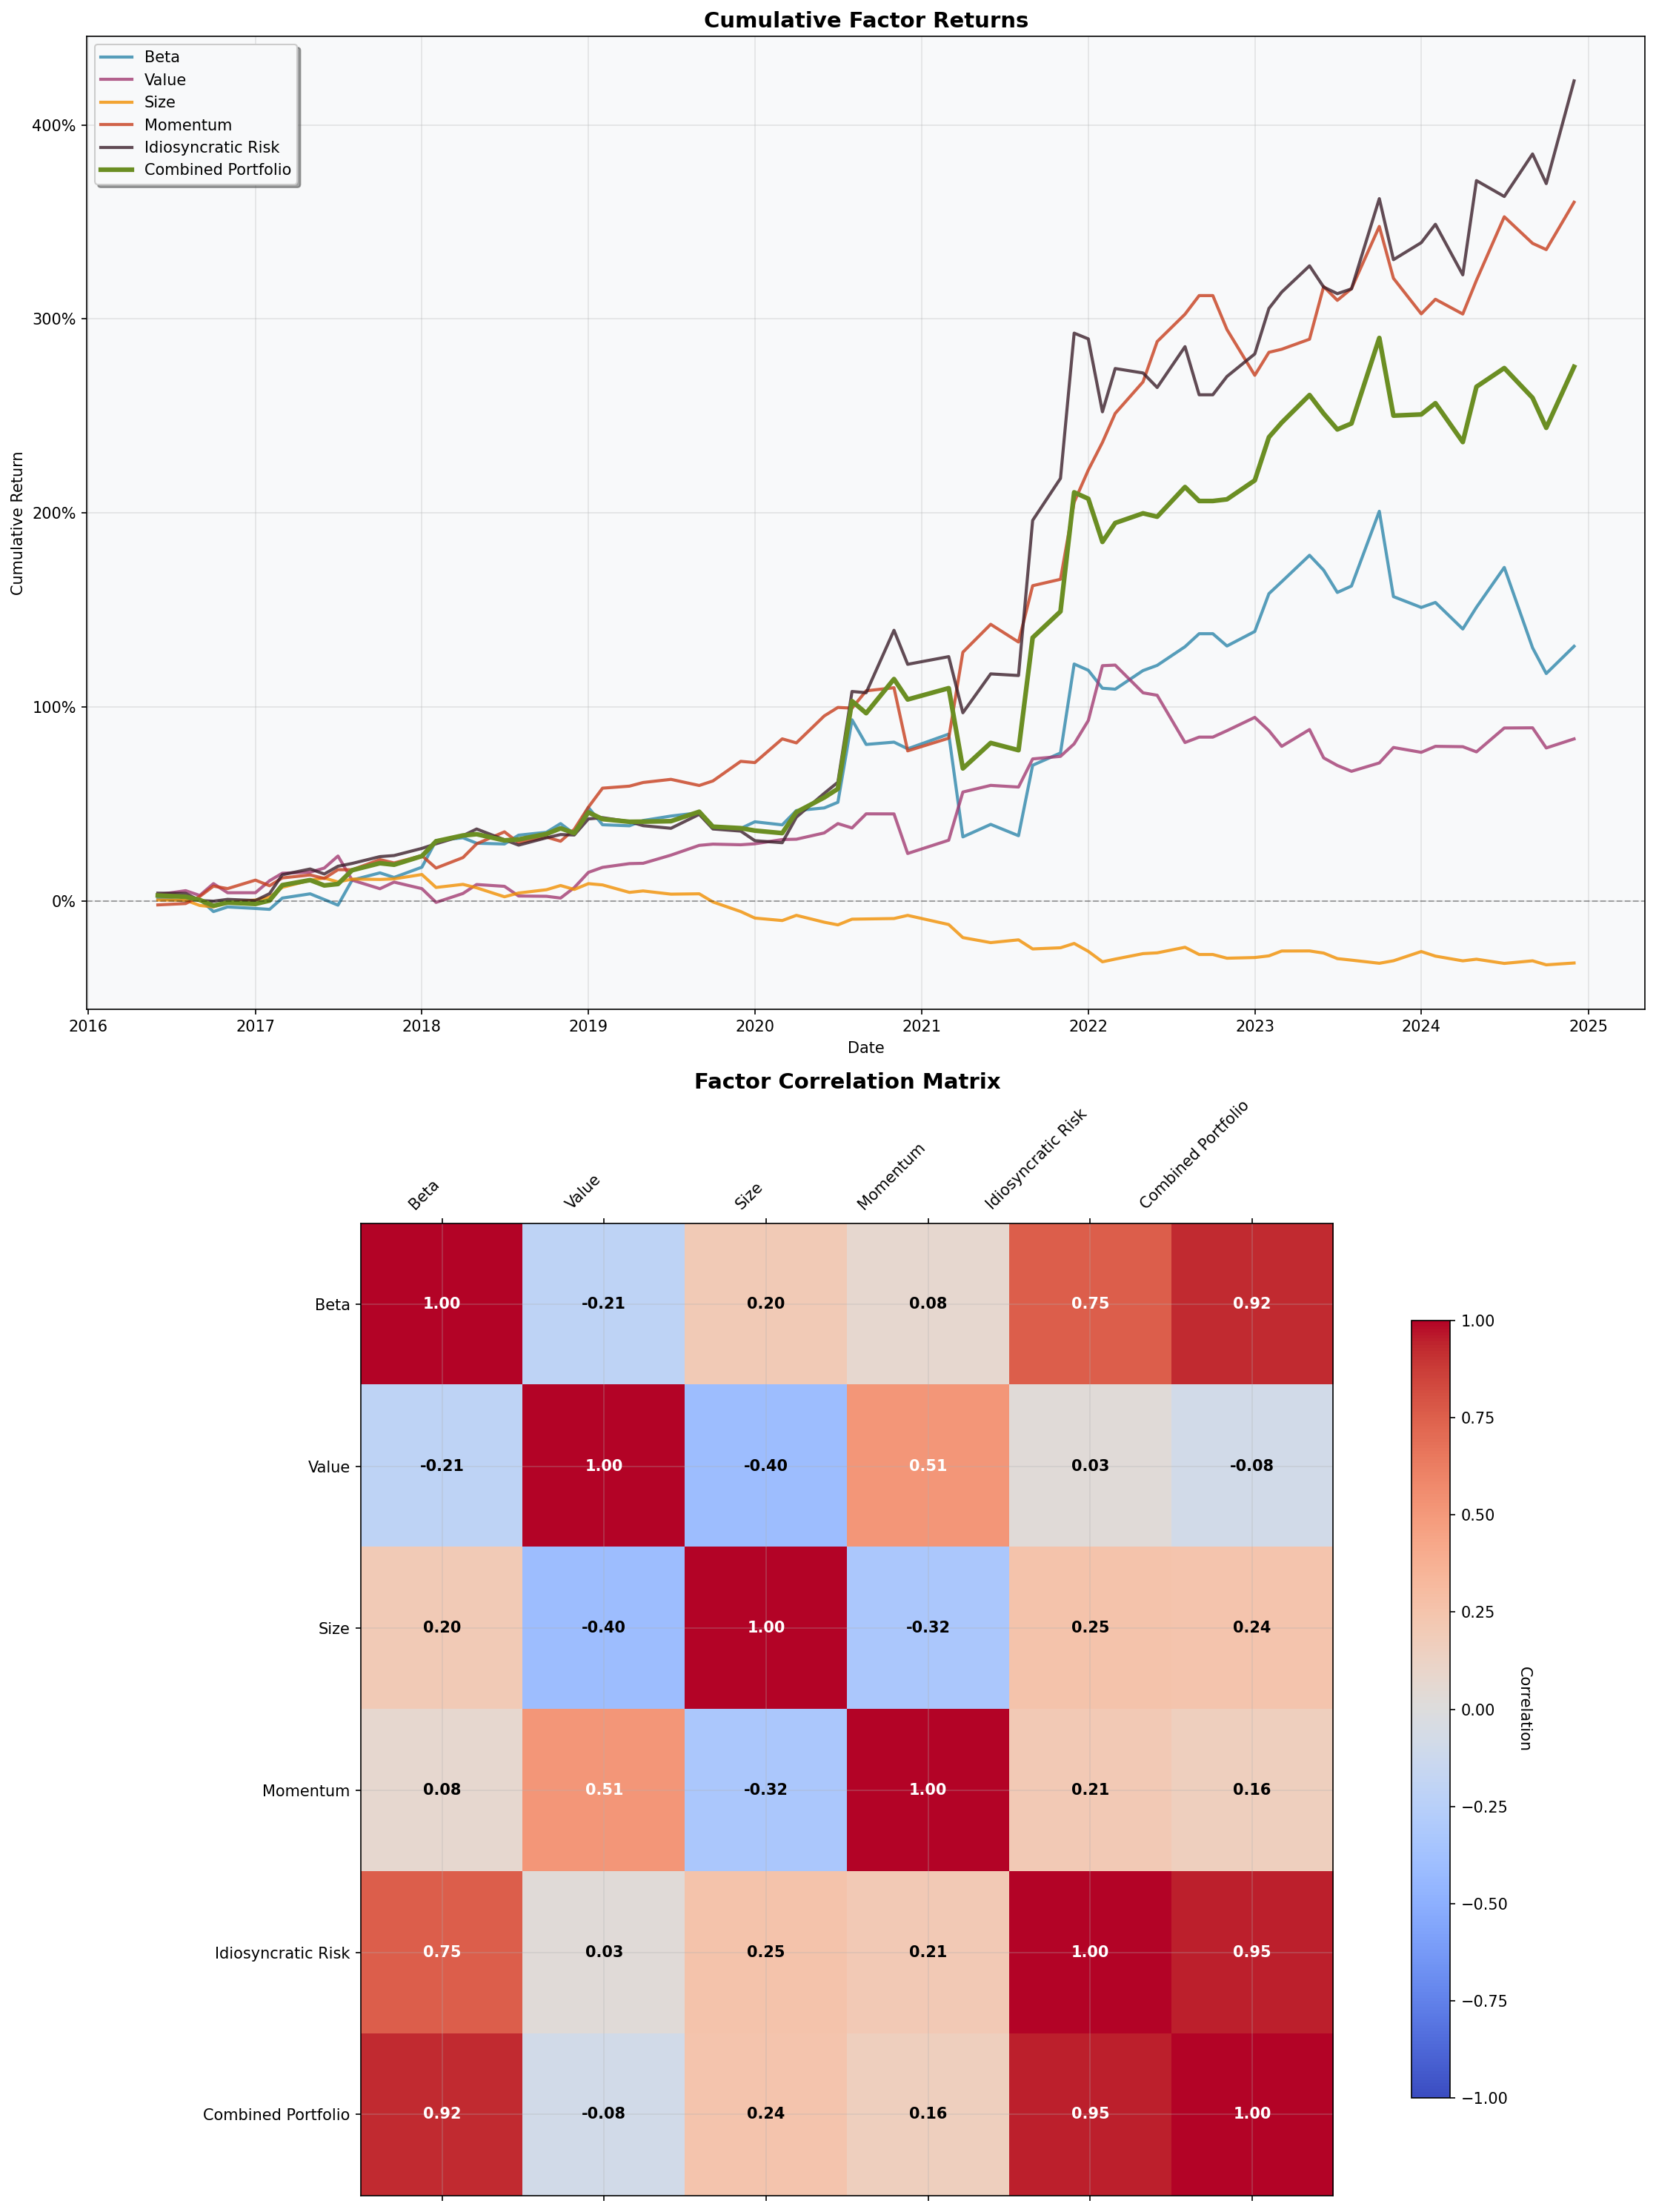

In [19]:
def carthart4_backtest():
    model = FactorModel()
    
    # define carhart-4 + idiosync. risk factors
    factor_names = ['beta', 'value', 'size', 'momentum', 'idiosyncratic_risk']
    
    # determine train / test split
    train_end = datetime.date(2010, 12, 31)
    test_start = datetime.date(2011, 1, 1)
    
    # run optimization (value-weighted)
    results = model.optimize_and_backtest_oos(
        train_end_date=train_end,
        test_start_date=test_start,
        optimization_method='mean_variance',
        n_quantiles=5,
        weighting='vw',
        factor_names=factor_names
    )
    
    if results is None:
        print("Backtest failed.")
        return
    
    test_model = results['test_model']
    test_model.plot_performance()

carthart4_backtest()

Training period:   1970-12-31 to 2010-12-31
Test period:       2011-01-01 to 2024-12-31

STEP 1: IN-SAMPLE OPTIMIZATION
OPTIMAL FACTOR WEIGHTS
beta                :   52.3%
idiosyncratic_risk  :   47.7%
momentum            :    0.0%
value               :    0.0%
size                :    0.0%
Combined portfolio created with 5 factors.

IN-SAMPLE Performance:

PERFORMANCE SUMMARY
Factor                   Return   Volatility     Sharpe      Alpha   Info Ratio
------------------------------------------------------------------------------------------
beta                      8.0%       15.7%     0.162     2.90%       0.185
value                     8.5%        7.8%     0.389     3.19%       0.404
size                      3.0%       11.7%    -0.208    -2.59%      -0.221
momentum                 17.3%       11.3%     1.042    11.72%       1.028
idiosyncratic_risk       10.8%       13.7%     0.389     5.48%       0.400
combined_portfolio        9.3%       13.6%     0.284     4.13%       0.30

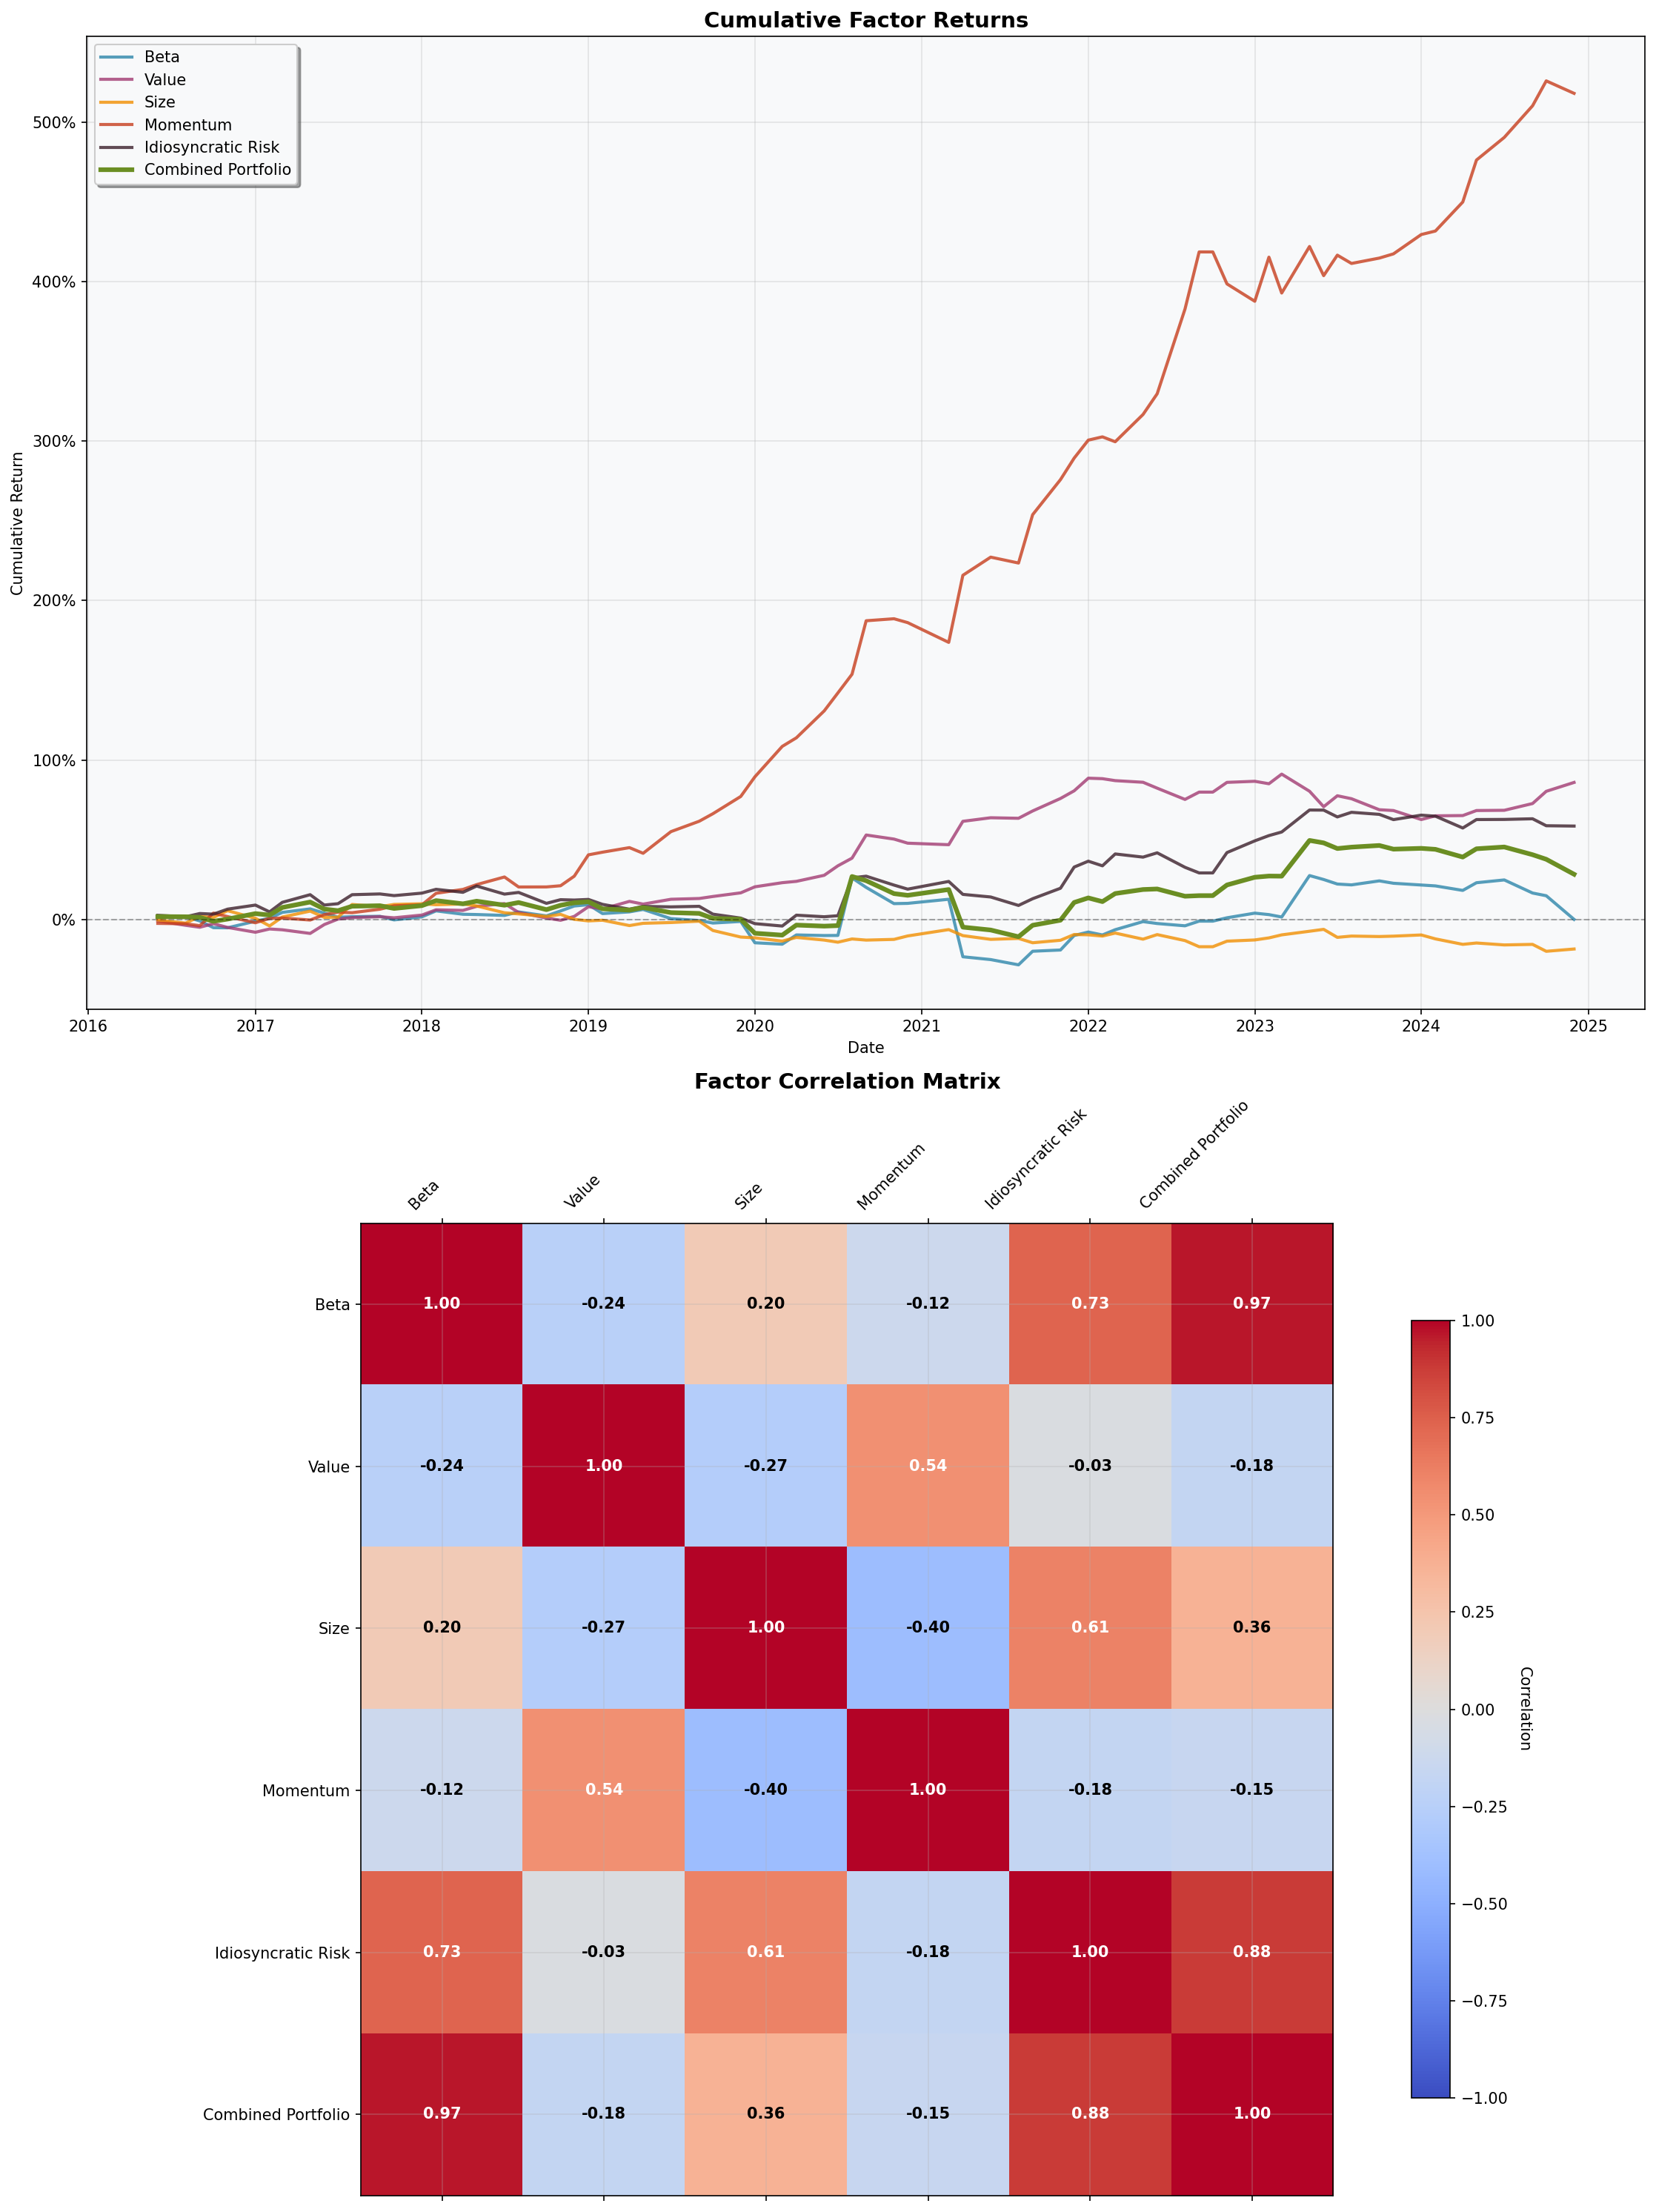

In [18]:
def carthart4_backtest():
    model = FactorModel()
    
    # define carhart-4 + idiosync. risk factors
    factor_names = ['beta', 'value', 'size', 'momentum', 'idiosyncratic_risk']
    
    # determine train / test split
    train_end = datetime.date(2010, 12, 31)
    test_start = datetime.date(2011, 1, 1)
    
    # run optimization (value-weighted)
    results = model.optimize_and_backtest_oos(
        train_end_date=train_end,
        test_start_date=test_start,
        optimization_method='mean_variance',
        n_quantiles=5,
        weighting='ew',
        factor_names=factor_names
    )
    
    if results is None:
        print("Backtest failed.")
        return
    
    test_model = results['test_model']
    test_model.plot_performance()

carthart4_backtest()

Training period:   1970-12-31 to 2010-12-31
Test period:       2011-01-01 to 2024-12-31

STEP 1: IN-SAMPLE OPTIMIZATION
OPTIMAL FACTOR WEIGHTS
beta                :   50.0%
idiosyncratic_risk  :   50.0%
Combined portfolio created with 2 factors.

IN-SAMPLE Performance:

PERFORMANCE SUMMARY
Factor                   Return   Volatility     Sharpe      Alpha   Info Ratio
------------------------------------------------------------------------------------------
beta                      5.7%       18.2%     0.013     0.18%       0.010
idiosyncratic_risk       11.5%       19.0%     0.318     5.37%       0.284
combined_portfolio        8.6%       16.3%     0.192     2.77%       0.170

STEP 2: OUT-OF-SAMPLE TESTING
Applying weights learned from training period...

Combined portfolio created with 2 factors.
OUT-OF-SAMPLE Performance:

PERFORMANCE SUMMARY
Factor                   Return   Volatility     Sharpe      Alpha   Info Ratio
-------------------------------------------------------------

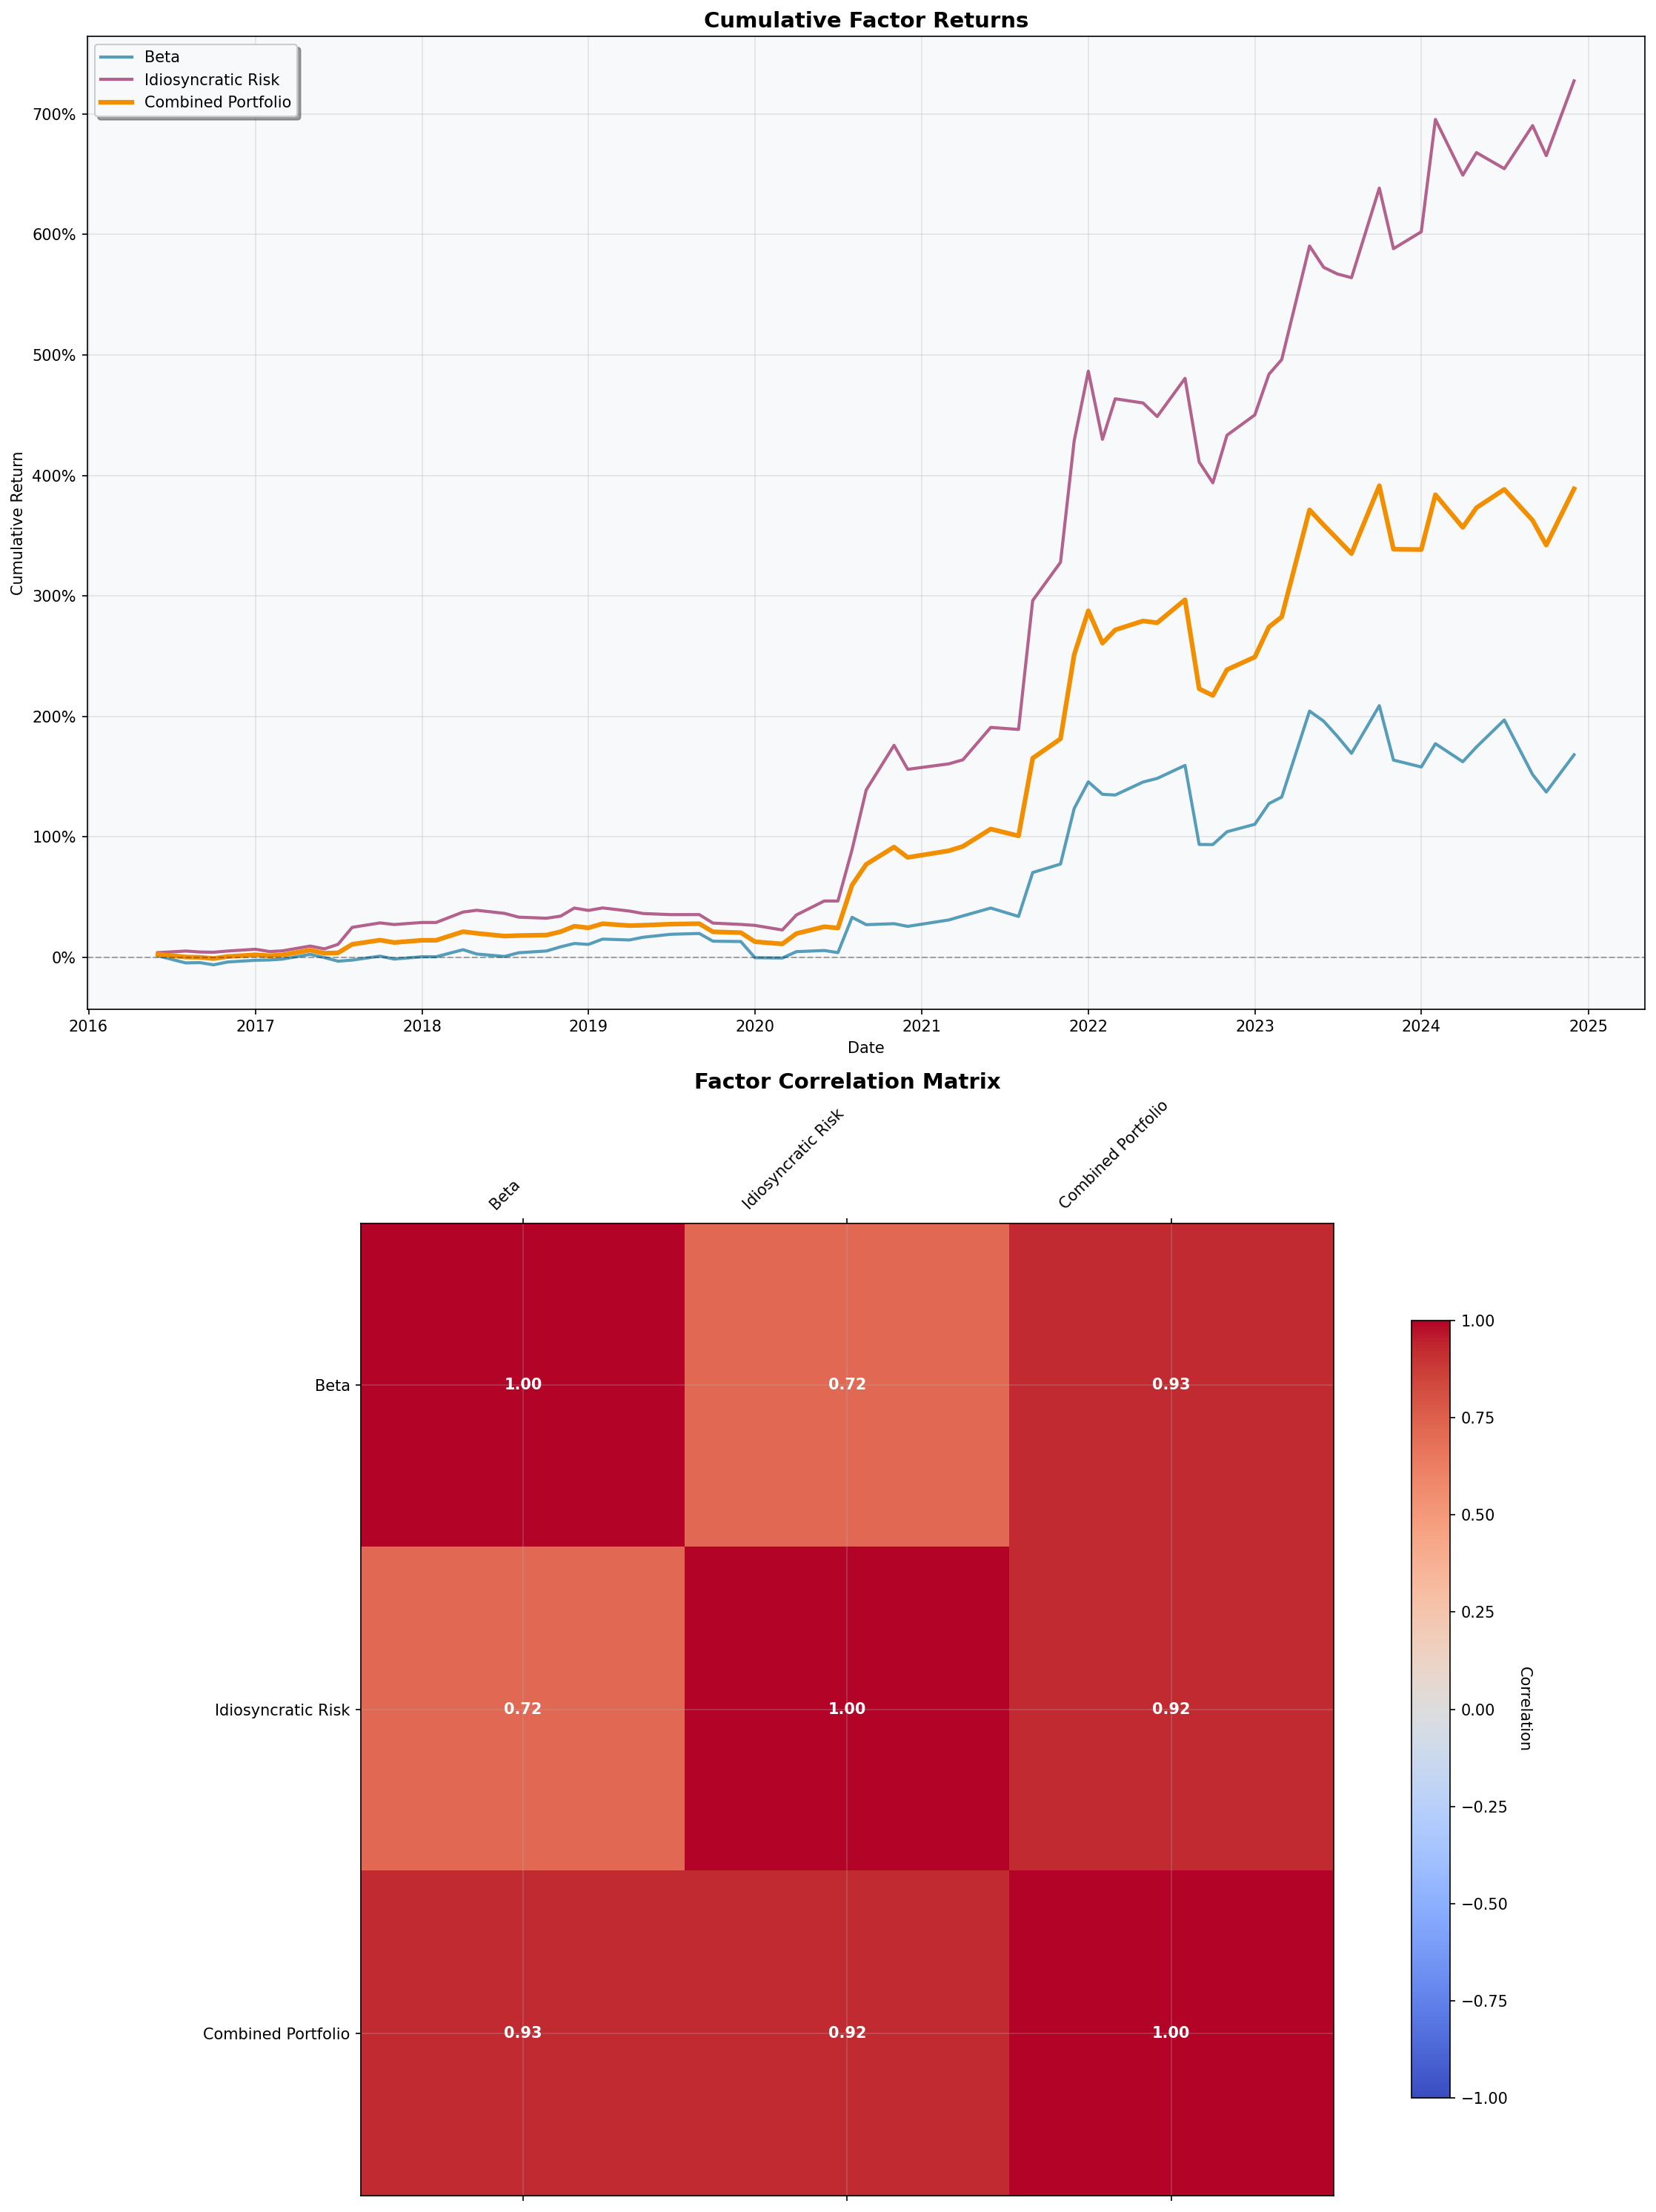

In [ ]:
def capm_backtest():
    model = FactorModel()
    
    # define carhart-4 + idiosync. risk factors
    factor_names = ['size', 'value', 'momentum', 'profitability', 'idiosyncratic_risk']
    factor_names = ['beta', 'idiosyncratic_risk']
    
    # determine train / test split
    train_end = datetime.date(2010, 12, 31)
    test_start = datetime.date(2011, 1, 1)
    
    # run optimization (value-weighted)
    results = model.optimize_and_backtest_oos(
        train_end_date=train_end,
        test_start_date=test_start,
        optimization_method='mean_variance',
        n_quantiles=5,
        weighting='vw',
        factor_names=factor_names
    )
    
    if results is None:
        print("Backtest failed.")
        return
    
    test_model = results['test_model']
    test_model.plot_performance()

capm_backtest()